In [1]:
import sys
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
sys.path.append('../../')

import numpy as np
import random
from IPython.display import Image

import torch
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10

from utils import show_first_batch, transform_data_for_show, show_forward, training, show_images, generate_new_images
from diffusion_models.ddpm import CustomDiffusionModel
from reverse_models.unet.unet import Unet
from metrics.rate_score import rate_score
from metrics.inception_score import inception_score
from metrics.fid_score import fid_score



SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
min_beta, max_beta = 10 ** -4, 0.02

# Read  and prepare dataset

Files already downloaded and verified


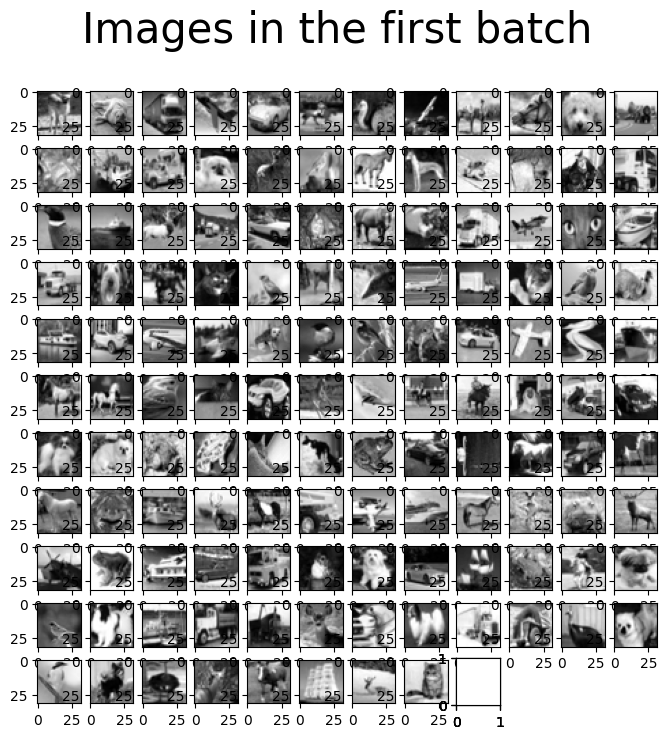

In [3]:
dataset = transform_data_for_show(CIFAR10, store_path='../../datasets')
train_dataloader = DataLoader(dataset, batch_size=128, num_workers=0, shuffle=True)
show_first_batch(train_dataloader)

In [4]:
size_pictures = next(iter(train_dataloader))[0].size()
image_channels = size_pictures[1]
hw = size_pictures[2]

# N_STEPS = 1000

In [5]:
n_steps = 1000

ddpm = CustomDiffusionModel(Unet(hw), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
#show_forward(ddpm, train_dataloader, device)

### Train

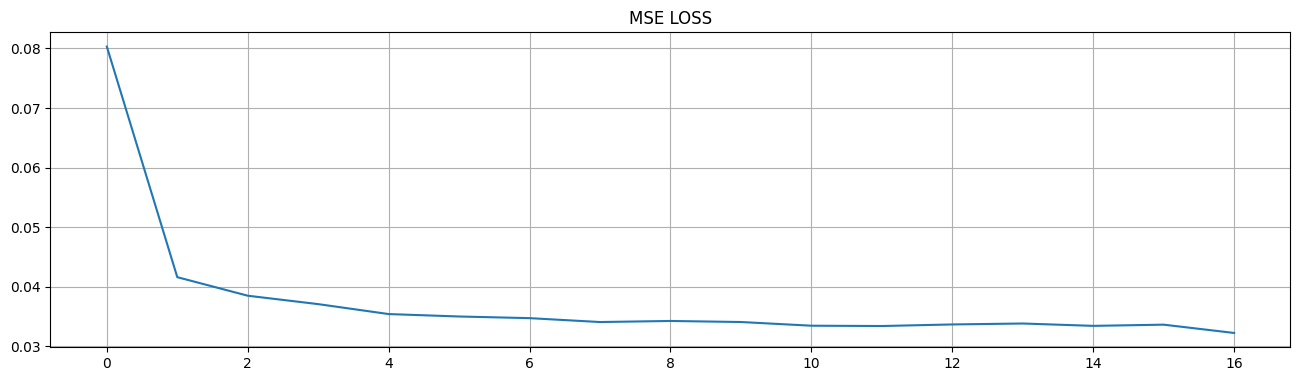

Loss at epoch 17: 0.03225 --> Best model ever (stored)


Epoch 18/20:   0%|          | 0/391 [00:00<?, ?it/s]

Loss at epoch 18: 0.03260


Epoch 19/20:   0%|          | 0/391 [00:00<?, ?it/s]

Loss at epoch 19: 0.03239


Epoch 20/20:   0%|          | 0/391 [00:00<?, ?it/s]

Loss at epoch 20: 0.03272


In [6]:
optimizer = torch.optim.Adam(ddpm.parameters(), lr=0.001)     
training(ddpm, train_dataloader, display=True, n_epochs=20, upset_epoch=4, device=device, optimizer=optimizer, store_path = '../../model_weights/ddpm_cifar_steps_1000.pt') 

### Test

In [6]:
store_path = '../../model_weights/ddpm_cifar_steps_1000.pt'

best_model = CustomDiffusionModel(Unet(hw), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


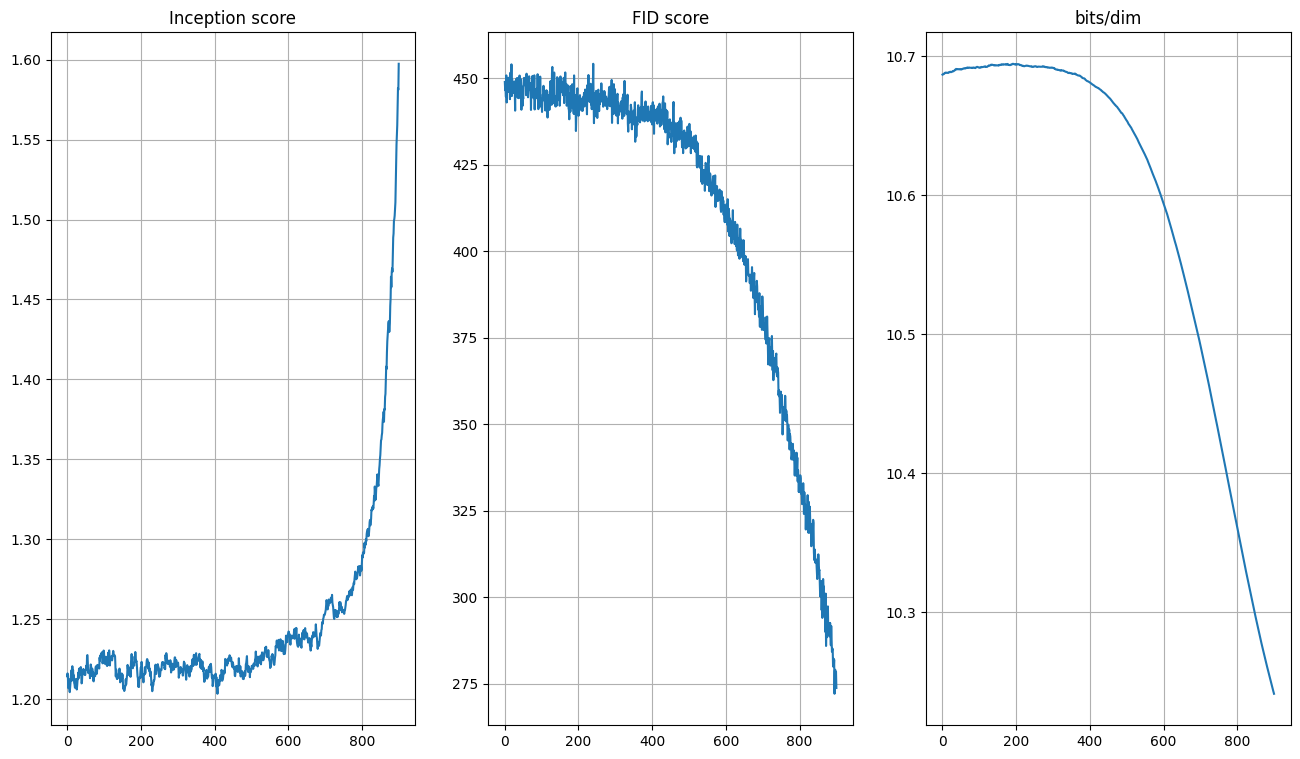

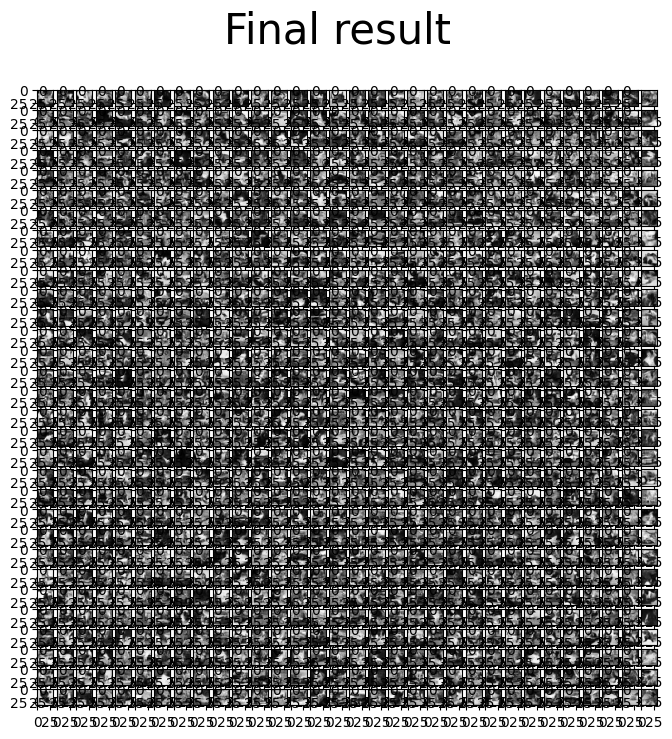

In [7]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=1000,
        show_metrics_pes_step=True,
        record_gif=False,
        dataset=dataset,
        device=device,
        gif_name="../../pictures/cifar_1000.gif",
        c=3, h=32, w=32
    )
show_images(generated, title="Final result")

In [ ]:
Image(open('../../pictures/cifar_1000.gif', 'rb').read())

### Metrics

In [9]:
print('bits_per_pixel = {}, N = 100, n_step = 1000'.format(rate_score(generated)))
inc_score, std = inception_score(generated, device=device, resize=True, splits=10)
print('inception_score = {}, inception_std = {}, N = 100, n_step = 1000'.format(inc_score, std))
rand_real_image = next(iter(DataLoader(dataset, batch_size=100, num_workers=0, shuffle=True)))[0].to(device)
print('fid_score = {}, N = 100, n_step = 1000'.format(fid_score(generated, rand_real_image)))

bits_per_pixel = 10.186698913574219, N = 100, n_step = 1000
inception_score = 3.5394300572450907, inception_std = 0.21779407271494644, N = 100, n_step = 1000
fid_score = 171.39408026973578, N = 100, n_step = 1000
